# Feature Engineering

In this notebook, I will focus on feature engineering and seeing how that may improve the performance of the LightGBM model I am currently working on.

## Potential Models to Submit

1. LGBM, all features, OHE of cat variables, on X scores: 0.7994213376003929. Submission score: 0.7306
2. LGBM, all features, OHE of cat variables + geo_level_1_id, on X scores: 0.7989033042850949. Submission score: 0.7319

Well this isn't good... now my model evaluation technique is no longer reliable. Model 2 scored lower on my evaluation but actually higher in real-life... 

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import lightgbm as lgb

from pathlib import Path
from lightgbm import LGBMClassifier
from pprint import pprint

from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV 
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

############ USE FOR GOOGLE COLAB ############
# DATA_DIR = Path('/content/drive/MyDrive/Work/Delivery/Current/Earthquake_damage/data')
# SUBMISSIONS_DIR = Path('drive/MyDrive/Work/Delivery/Current/Earthquake_damage/submissions')
# MODEL_DIR = Path('/content/drive/MyDrive/Work/Delivery/Current/Earthquake_damage/models')
# MY_DATA_DIR = PATH('/content/drive/MyDrive/Work/Delivery/Current/Earthquake_damage/my_data')

# from google.colab import drive
# drive.mount('/content/drive')
#############################################


### USE FOR LOCAL JUPYTER NOTEBOOKS ###
DATA_DIR = Path('data')
SUBMISSIONS_DIR = Path('submissions')
MODEL_DIR = Path('models')
MY_DATA_DIR = Path('my_data')
#######################################

# The code runs the same if working on Jupyter or Colab, just need to change the 
# dirs above

X = pd.read_csv(DATA_DIR / 'train_values.csv', index_col='building_id')

categorical_columns = X.select_dtypes(include='object').columns
bool_columns = [col for col in X.columns if col.startswith('has')]
X[categorical_columns] = X[categorical_columns].astype('category')
X[bool_columns] = X[bool_columns].astype('bool')

# X = pd.get_dummies(X)
y = pd.read_csv(DATA_DIR / 'train_labels.csv', index_col='building_id')

lgbm_hyperparams = {'num_leaves': 120,
                    'n_estimators': 240,
                    'min_child_samples': 40,
                    'learning_rate': 0.2,
                    'boosting_type': 'goss'}

In [3]:
sns.set()

In [4]:
def make_submission(pipeline, title):
    """
    Given a trained pipeline object, use it to make predictions on the 
    submission test set 'test_values.csv' and write them a csv in the submissions
    folder.
    """
    # Read in test_values csv and apply data preprocessing
    # note: will create a data preprocessing pipeline or function in future
    test_values = pd.read_csv(DATA_DIR / 'test_values.csv', index_col='building_id')
    test_values[categorical_columns] = test_values[categorical_columns].astype('category')
    test_values[bool_columns] = test_values[bool_columns].astype('bool')

    # Generate predictions using pipeline we pass in
    predictions = pipeline.predict(test_values)

    submission_format = pd.read_csv(DATA_DIR / 'submission_format.csv',
                                    index_col='building_id')

    my_submission = pd.DataFrame(data=predictions,
                                columns=submission_format.columns,
                                index=submission_format.index)
    
    my_submission.to_csv(SUBMISSIONS_DIR / f'{title}.csv')

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33,
                                                  random_state=42, stratify=y,
                                                  shuffle=True)

In [3]:
X.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
28830,8,900,2812,2,10,8,7,o,r,n,...,False,False,False,False,False,False,False,False,False,False
94947,21,363,8973,2,10,5,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
590882,22,418,10694,2,10,6,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
201944,11,131,1488,3,30,8,9,t,r,n,...,False,False,False,False,False,False,False,False,False,False


## Function to test which categorical variables to encode

In [42]:
def lgbm_vary_categorical_variables(categorical_columns):
    """
    Build a LGBM model using the best hyperparameters we have (as of 09/02/21)
    and vary which columns are one-hot encoded.
    
    Pass the columns you wish to OHE as cat_variables.
    """
    t = [('ohe', OneHotEncoder(), categorical_columns)]
    ct = ColumnTransformer(transformers=t, remainder='passthrough')

    lgbm_hyperparams = {'num_leaves': 120,
                        'n_estimators': 240,
                        'min_child_samples': 40,
                        'learning_rate': 0.2,
                        'boosting_type': 'goss'}

    steps = [('ct', ct),
             ('lgbm', LGBMClassifier(**lgbm_hyperparams))]

    pipe = Pipeline(steps)
    pipe.fit(X, np.ravel(y))
    
    y_pred_X = pipe.predict(X)
    y_pred_X_val = pipe.predict(X_val)
    
    f1_score_X = f1_score(y, y_pred_X, average='micro')
    f1_score_X_val = f1_score(y_val, y_pred_X_val, average='micro')
    
    print('F1 score on X:    ', f1_score_X)
    print('F1 score on X_val:', f1_score_X_val)
    
    return pipe

## Encode all categorical features as categorical and make Pipeline

In [18]:
lgbm_cat_cols = lgbm_vary_categorical_variables(categorical_columns)

F1 score on X:     0.7994213376003929
F1 score on X_val: 0.8013930394539471


In [59]:
make_submission(lgbm_cat_cols, '09-02 LGBM all features, lgbm_02_02 hyperparameters')

## Encode geo_level_1_id as categorical

In [13]:
cat_cols_plus_geo_1 = categorical_columns.insert(0, 'geo_level_1_id')
cat_cols_plus_geo_1

Index(['geo_level_1_id', 'land_surface_condition', 'foundation_type',
       'roof_type', 'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'legal_ownership_status'],
      dtype='object')

In [19]:
lgbm_plus_geo_1 = lgbm_vary_categorical_variables(cat_cols_plus_geo_1)

F1 score on X:     0.7989033042850949
F1 score on X_val: 0.7994046442400493


In [61]:
make_submission(lgbm_plus_geo_1, '09-02 LGBM all features, geo_level_1_id OHE, lgbm_02_02 hyperparameters')

## Encode first two geo_levels as categorical

In [55]:
cat_cols_plus_2_geos = ['geo_level_1_id', 'geo_level_2_id',
                          'land_surface_condition', 'foundation_type',
                           'roof_type', 'ground_floor_type', 'other_floor_type', 
                          'position','plan_configuration', 'legal_ownership_status']

In [56]:
lgbm_plus_2_geos = lgbm_vary_categorical_variables(cat_cols_plus_2_geos)

F1 score on X:     0.789739870530044
F1 score on X_val: 0.7910440819079292


## Encode all geo_levels as categorical

This doesn't help, actually makes it worse. Perhaps because we are splitting it into THOUSANDS of different features?

In [33]:
cat_cols_plus_all_geos = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
                          'land_surface_condition', 'foundation_type',
                           'roof_type', 'ground_floor_type', 'other_floor_type', 
                          'position','plan_configuration', 'legal_ownership_status']

In [34]:
lgbm_plus_all_geos = lgbm_vary_categorical_variables(cat_cols_plus_all_geos)

F1 score on X:     0.7771497423263917
F1 score on X_val: 0.7790555704136095


## Geo level 1 with top 14 features

In [44]:
X_dummies = pd.get_dummies(X)

In [48]:
any(elem in categorical_columns for elem in top_14_features)

False

In [46]:
X_dummies[top_14_features]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 14 columns):
 #   Column                                  Non-Null Count   Dtype
---  ------                                  --------------   -----
 0   geo_level_1_id                          260601 non-null  int64
 1   geo_level_2_id                          260601 non-null  int64
 2   geo_level_3_id                          260601 non-null  int64
 3   count_floors_pre_eq                     260601 non-null  int64
 4   age                                     260601 non-null  int64
 5   area_percentage                         260601 non-null  int64
 6   height_percentage                       260601 non-null  int64
 7   has_superstructure_mud_mortar_stone     260601 non-null  bool 
 8   has_superstructure_stone_flag           260601 non-null  bool 
 9   has_superstructure_mud_mortar_brick     260601 non-null  bool 
 10  has_superstructure_cement_mortar_brick  260601 non-null  bool 


In [35]:
top_14_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 
                    'count_floors_pre_eq', 'age'	, 'area_percentage'	, 
                    'height_percentage', 
                    'has_superstructure_mud_mortar_stone',
                    'has_superstructure_stone_flag', 
                    'has_superstructure_mud_mortar_brick',
                    'has_superstructure_cement_mortar_brick',
                    'has_superstructure_timber', 'count_families',
                    'other_floor_type_q']

In [49]:
def lgbm_encoded_geo_level_variables_with_top_14_features(geo_level_id_cols, X, y):
    """
    Build LGBM classifier using the top_14_features subset and a custom
    number of columns you want to make categorical. The only columns to choose
    from are the geo_level_i_id columns (since all other categorical cols are
    not included in the top_14_features list).
    
    This is to test how many of the geo_level_i_id columns should be one hot encoded
    """
    X = pd.get_dummies(X)
    X = X[top_14_features]
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33,
                                                      random_state=42, stratify=y,
                                                      shuffle=True)

    lgbm_hyperparams = {'num_leaves': 120,
                        'n_estimators': 240,
                        'min_child_samples': 40,
                        'learning_rate': 0.2,
                        'boosting_type': 'goss'}
    
    t = [('ohe', OneHotEncoder(), geo_level_id_cols)]

    steps = [('ct', ColumnTransformer(transformers=t, remainder='passthrough')),
             ('lgbm', LGBMClassifier(**lgbm_hyperparams))]

    pipe = Pipeline(steps)
    pipe.fit(X, np.ravel(y))
    
    y_pred_X = pipe.predict(X)
    y_pred_X_val = pipe.predict(X_val)
    
    f1_score_X = f1_score(y, y_pred_X, average='micro')
    f1_score_X_val = f1_score(y_val, y_pred_X_val, average='micro')
    
    print('F1 score on X:    ', f1_score_X)
    print('F1 score on X_val:', f1_score_X_val)
    
    return pipe

In [51]:
lgbm_encoded_geo_level_variables_with_top_14_features([], X, y)

F1 score on X:     0.7875104086323538
F1 score on X_val: 0.7891952232002698


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe', OneHotEncoder(),
                                                  [])])),
                ('lgbm',
                 LGBMClassifier(boosting_type='goss', learning_rate=0.2,
                                min_child_samples=40, n_estimators=240,
                                num_leaves=120))])

In [50]:
lgbm_encoded_geo_level_variables_with_top_14_features(['geo_level_1_id'], X, y)

F1 score on X:     0.786236430405102
F1 score on X_val: 0.7876835777160199


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe', OneHotEncoder(),
                                                  ['geo_level_1_id'])])),
                ('lgbm',
                 LGBMClassifier(boosting_type='goss', learning_rate=0.2,
                                min_child_samples=40, n_estimators=240,
                                num_leaves=120))])

In [53]:
geo_level_id_cols = ['geo_level_1_id', 'geo_level_2_id']
lgbm_encoded_geo_level_variables_with_top_14_features(geo_level_id_cols, X, y)

F1 score on X:     0.7754306391763655
F1 score on X_val: 0.7773927603809345


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe', OneHotEncoder(),
                                                  ['geo_level_1_id',
                                                   'geo_level_2_id'])])),
                ('lgbm',
                 LGBMClassifier(boosting_type='goss', learning_rate=0.2,
                                min_child_samples=40, n_estimators=240,
                                num_leaves=120))])

In [52]:
geo_level_id_cols = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
lgbm_encoded_geo_level_variables_with_top_14_features(geo_level_id_cols, X, y)

F1 score on X:     0.7621804981561852
F1 score on X_val: 0.7637530668961267


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe', OneHotEncoder(),
                                                  ['geo_level_1_id',
                                                   'geo_level_2_id',
                                                   'geo_level_3_id'])])),
                ('lgbm',
                 LGBMClassifier(boosting_type='goss', learning_rate=0.2,
                                min_child_samples=40, n_estimators=240,
                                num_leaves=120))])

## Boxplots

In [32]:
df = X.join(y)

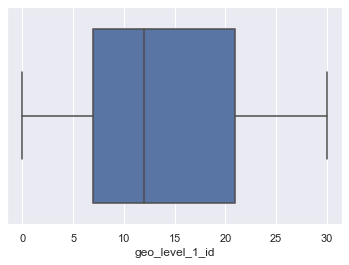

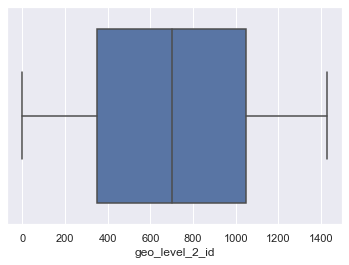

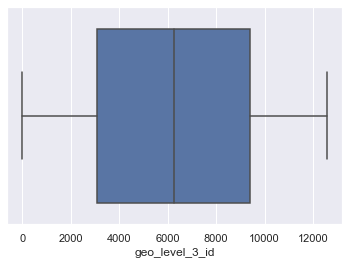

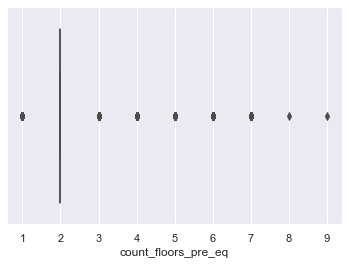

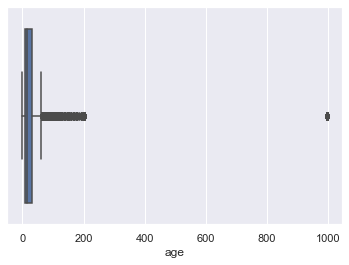

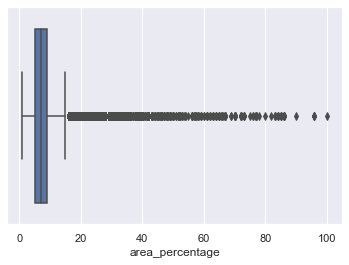

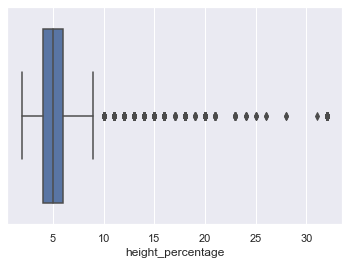

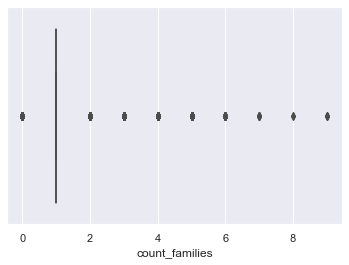

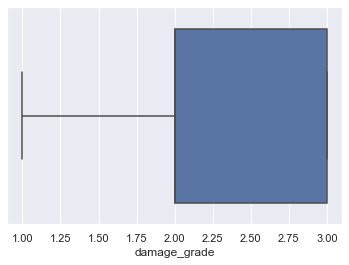

In [28]:
for col in df.select_dtypes('number'):
    sns.boxplot(x=df[col])
    plt.show()

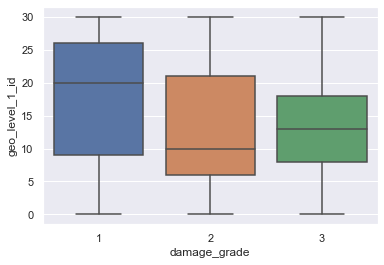

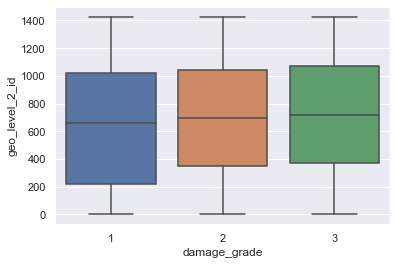

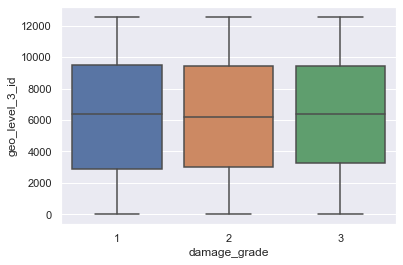

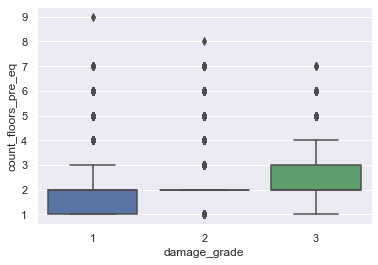

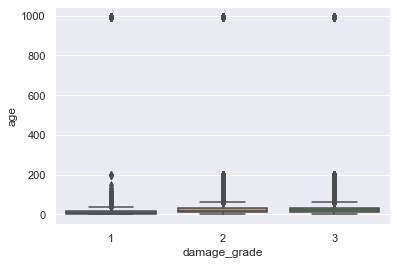

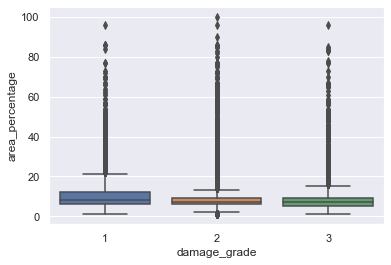

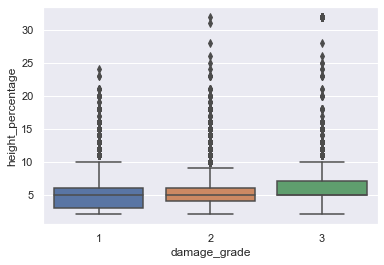

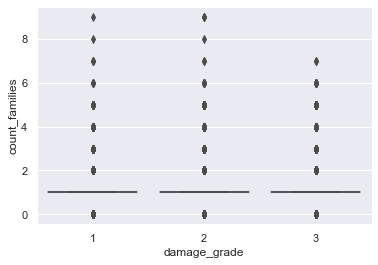

In [31]:
for col in df.select_dtypes('number').columns[:-1]:
    sns.boxplot(x='damage_grade', y=col, data=df)
    plt.show()

## Checking FIs without OHE geo_level_1_id

In [42]:
X_dummies = pd.get_dummies(X)
model = LGBMClassifier(**lgbm_hyperparams)
model.fit(X_dummies, np.ravel(y))
s_fi_dummies = pd.Series(data=model.feature_importances_,
                         index=X_dummies.columns,
                         name='FI')
s_fi_dummies.sort_values(ascending=False).to_csv(MY_DATA_DIR / 'FIs_ohe_just_categorical_vars.csv')

## Checking Feature Importances After geo_level_1_id is encoded

TL;DR
Encoding `geo_level_1_id` and `geo_level_2_id` produce some useful features (some as high as 600 feature importance!). Now it's time to explore how many of those we should keep.

From EDA we can see that some of the geo_level_1_id locations have a LOT of predictive power. Perhaps one reason for a lack of lift in the models is that we have introduced loads of unhelpful features. 

So,
1. Build a model with geo_level_1_id encoded and check all the feature importances
2. What happens to the features when we apply OHE? How can I accurately select the most important ones afterwards? How do I know which features are which? One easier way would be to use the pd.get_dummies() function.
2. Remove all the features with 0 importance, then iteratively remove more and more features until I find an optimal amount (based on the feature importances).



In [5]:
cat_cols_plus_geo_1 = categorical_columns.insert(0, 'geo_level_1_id')
cat_cols_plus_geo_1

Index(['geo_level_1_id', 'land_surface_condition', 'foundation_type',
       'roof_type', 'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'legal_ownership_status'],
      dtype='object')

In [10]:
X.loc[:, 'geo_level_1_id'] = X.loc[:, 'geo_level_1_id'].astype('category')

In [16]:
X_ohe = pd.get_dummies(X)

In [17]:
lgbm_hyperparams = {'num_leaves': 120,
                    'n_estimators': 240,
                    'min_child_samples': 40,
                    'learning_rate': 0.2,
                    'boosting_type': 'goss'}

In [20]:
model = LGBMClassifier(**lgbm_hyperparams)
model.fit(X_ohe, np.ravel(y))

LGBMClassifier(boosting_type='goss', learning_rate=0.2, min_child_samples=40,
               n_estimators=240, num_leaves=120)

In [21]:
model.feature_importances_

array([16004, 17268,  1418,  7355,  8344,  4844,   558,   869,   388,
         312,   463,   607,  1144,   627,   439,   196,   247,  1378,
         635,   386,   320,   153,    34,     2,    48,     1,     0,
           0,   132,   243,   217,   102,   263,   467,   260,   604,
         546,   513,   233,   543,   308,   191,   417,   143,   132,
         239,   563,   202,    37,   461,   426,   350,    95,   113,
         354,   545,   407,    22,    90,   248,   591,   276,   619,
          99,   249,   551,   399,   338,   865,   621,   295,   646,
          58,   381,   574,    70,   235,   950,   275,   698,   390,
         141,   710,   597,    32,    40,   307,     0,     0,     0,
          12,   209,    51,   186,   207,    91,   254,   157],
      dtype=int32)

In [28]:
s_fi = pd.Series(data=model.feature_importances_,
                  index=X_ohe.columns,
                  name='FI')

In [38]:
s_fi.sort_values(ascending=False).to_csv(MY_DATA_DIR / 'feature_importances_geo_level_1_id_ohe.csv')

## FIs with first 2 geo_level_i_id columns OHE'd

Probably too many

In [10]:
X_geo_categorical = X.copy()
X_geo_categorical.iloc[:, [0, 1]] = X_geo_categorical.iloc[:, [0, 1]].astype('category')

In [11]:
X_geo_categorical_dummies = pd.get_dummies(X_geo_categorical)

In [12]:
len(X_geo_categorical_dummies.columns)

1511

In [13]:
def fit_and_save_feature_importances(df, title):
    model = LGBMClassifier(**lgbm_hyperparams)
    model.fit(df, np.ravel(y))
    s_fi = pd.Series(data=model.feature_importances_,
                     index=df.columns,
                     name='FI')
    s_fi.sort_values(ascending=False).to_csv(MY_DATA_DIR / f'{title}.csv')

In [14]:
fit_and_save_feature_importances(X_geo_categorical_dummies,
                                'FIs_geo_levels_1+2_OHE')

## Feature Selection using SelectFromModel

We've seen that encoding geo_levels 1 and 2 into categorical variables leads to many valuable features being created. Let's build a suite of models now with both geo_level_1 and geo_levels 1+2 encoded and see which models give the best score when trained on X and evaluted on both X and X_val

Let's see how we get on


In [22]:
X_geo_level_1_ohe = X.copy()
X_geo_level_1_ohe.iloc[:, 0] = X_geo_level_1_ohe.iloc[:, 0].astype('category')
X_geo_level_1_ohe = pd.get_dummies(X_geo_level_1_ohe)

X_geo_levels_1_and_2_ohe = X.copy()
X_geo_levels_1_and_2_ohe.iloc[:, [0, 1]] = X_geo_levels_1_and_2_ohe.iloc[:, [0, 1]]\
                                            .astype('category')
X_geo_levels_1_and_2_ohe = pd.get_dummies(X_geo_levels_1_and_2_ohe)

In [31]:
def feature_selection_with_FI(df, thresh='mean'):

    lgbm_selector = LGBMClassifier(**lgbm_hyperparams)
    lgbm = LGBMClassifier(**lgbm_hyperparams)

    # Want to modify the threshold and see how it influences results
    # can this be done with GridSearchCV?
    selector = SelectFromModel(estimator=lgbm_selector, threshold=thresh)

    steps = [('selector', selector),
             ('lgbm', lgbm)]

    pipe = Pipeline(steps)

    pipe.fit(df, np.ravel(y))
    
    y_pred = pipe.predict(df)
    score = f1_score(y, y_pred, average='micro')
    print('Threshold:', thresh)
    print('F1 score: ', score)

In [32]:
thresholds = [0, 100, 200, 300, 400, 500, 600, 1000]
for thresh in thresholds:
    feature_selection_with_FI(X_geo_level_1_ohe, thresh=thresh)

Threshold: 0
F1 score:  0.7980936373997028
Threshold: 100
F1 score:  0.7993254055049673
Threshold: 200
F1 score:  0.7978096783972433
Threshold: 300
F1 score:  0.7969309404031449
Threshold: 400
F1 score:  0.7938342523628075
Threshold: 500
F1 score:  0.7894328878246821
Threshold: 600
F1 score:  0.7781858089569879
Threshold: 1000
F1 score:  0.7548244250789521


From this it looks like having more features is better but this could just be because it is learning the mapping. Let's try it with GridSearch and see what scores I get based on each.

In [36]:
lgbm_selector = LGBMClassifier(**lgbm_hyperparams)
lgbm = LGBMClassifier(**lgbm_hyperparams)

# Want to modify the threshold and see how it influences results
# can this be done with GridSearchCV?
selector = SelectFromModel(estimator=lgbm_selector)

steps = [('selector', selector),
         ('lgbm', lgbm)]

pipe = Pipeline(steps)

thresholds = [0, 50, 100, 200, 300, 400, 500, 600, 1000]

param_grid = {'selector__threshold': thresholds}

gs = GridSearchCV(pipe, param_grid, scoring='f1_micro', n_jobs=-1,
                 cv=5, verbose=10)

lgbm_geo_level_1_feature_selected = gs.fit(X_geo_level_1_ohe, np.ravel(y))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done  35 out of  45 | elapsed: 11.8min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed: 11.8min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 13.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 13.3min finished


In [37]:
# It got 0.7303 upon submission (this is great that this score is trustworthy!)
lgbm_geo_level_1_feature_selected.best_score_

0.7305497616142425

In [39]:
lgbm_geo_level_1_feature_selected.best_params_

{'selector__threshold': 0}

In [41]:
pd.DataFrame(lgbm_geo_level_1_feature_selected.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_selector__threshold,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,119.778302,0.288099,37.102774,0.352343,0,{'selector__threshold': 0},0.732123,0.726497,0.734171,0.730602,0.729355,0.730550,0.002586,1
1,115.195775,3.476986,35.175505,1.100775,50,{'selector__threshold': 50},0.729879,0.726209,0.732118,0.729720,0.731830,0.729951,0.002111,3
2,110.689862,0.432387,36.302597,0.308717,100,{'selector__threshold': 100},0.730493,0.725384,0.732924,0.730564,0.729988,0.729871,0.002463,4
3,106.785542,2.395566,33.280596,1.420925,200,{'selector__threshold': 200},0.730032,0.727552,0.731984,0.730986,0.730814,0.730273,0.001496,2
4,103.684138,1.110231,32.755417,1.333658,300,{'selector__threshold': 300},0.726962,0.723734,0.728799,0.727763,0.726592,0.726770,0.001696,5
5,103.527036,0.337071,33.579008,0.504491,400,{'selector__threshold': 400},0.725715,0.722371,0.725480,0.727168,0.725000,0.725147,0.001565,6
6,99.686676,2.579058,30.742865,1.891132,500,{'selector__threshold': 500},0.718866,0.714236,0.722218,0.719321,0.719474,0.718823,0.002578,7
7,94.781123,1.591962,29.672820,0.959576,600,{'selector__threshold': 600},0.705167,0.700729,0.702513,0.704298,0.707540,0.704049,0.002319,8
8,72.646262,1.717849,17.434321,0.500402,1000,{'selector__threshold': 1000},0.689530,0.688162,0.692728,0.690925,0.691884,0.690646,0.001635,9


Based off of these scores, lets select thresholds 200 and 0 and submit scores and see what we get.

In [ ]:
def make_submission(pipeline, title):
    """
    Given a trained pipeline object, use it to make predictions on the 
    submission test set 'test_values.csv' and write them a csv in the submissions
    folder.
    """
    # Read in test_values csv and apply data preprocessing
    # note: will create a data preprocessing pipeline or function in future
    test_values = pd.read_csv(DATA_DIR / 'test_values.csv', index_col='building_id')
    test_values[categorical_columns] = test_values[categorical_columns].astype('category')
    test_values[bool_columns] = test_values[bool_columns].astype('bool')

    # Generate predictions using pipeline we pass in
    predictions = pipeline.predict(test_values)

    submission_format = pd.read_csv(DATA_DIR / 'submission_format.csv',
                                    index_col='building_id')

    my_submission = pd.DataFrame(data=predictions,
                                columns=submission_format.columns,
                                index=submission_format.index)
    
    my_submission.to_csv(SUBMISSIONS_DIR / f'{title}.csv')

In [42]:
test_values = pd.read_csv(DATA_DIR / 'test_values.csv', index_col='building_id')
test_values[categorical_columns] = test_values[categorical_columns].astype('category')
test_values[bool_columns] = test_values[bool_columns].astype('bool')
# OHE geo_level_1_id column
test_values.iloc[:, 0] = test_values.iloc[:, 0].astype('category')
test_values = pd.get_dummies(test_values)

# Add in custom model
predictions = lgbm_geo_level_1_feature_selected.predict(test_values)

submission_format = pd.read_csv(DATA_DIR / 'submission_format.csv',
                                index_col='building_id')

my_submission = pd.DataFrame(data=predictions,
                            columns=submission_format.columns,
                            index=submission_format.index)
# Change title
title = 'LGBM lgbm_02_02 hyperparams - geo_level_1_id OHE, feature importance threshold=0'
my_submission.to_csv(SUBMISSIONS_DIR / f'{title}.csv')